## Descarga y preparacion del dataset

Como el dataset es enorme (83 GB) y las imagenes son pesadas  (alta resolucion), en esta notebook descargamos los datos desde kaggle y creamos datasets con las imagenes en una menor escala de resolucion (un dataset con la mitad de la resolucion y otro con un cuarto de la resolucion). La idea es que esto nos pueda servir para probar modelos en mayores y menores resoluciones si asi lo requiriera el problema. Sin embargo, en un primer acercamiento crear un modelo que trabaje en tan alta resolucion significaria empezar con un modelo muy complejo, preferimos empezar con un modelo que trabaje con imagenes mas chicas e ir incrementando la complejidad si eso diera beneficio en el performance. Este proceso de escalar las imagenes queremos hacerlo antes de correr el modelo para que el dataset pueda entrar tambien en maquinas mas chicas, esta notebook solo corre si se tienen unos 300GB de espacio libre.

## Importacion del dataset

Instalo la API de kaggle y me traigo las credenciales para utilizarla

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 1.9 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.9-py3-none-any.whl size=73265 sha256=276794b7ea0f9fc3b4d8b1c3515c895eaf045cb8ba4d71ecf1c4a855268fd345
  Stored in directory: /home/jupyter/.cache/pip/wheels/09/25/76/1bbe8ad0c423e8655942b6d3c781f58e0ea2791bf8ee8985b3
Successfully built kaggle


In [2]:
# Upload kaggle.json
!mkdir .tmp
!gsutil cp gs://diabetic-detection/credentials/kaggle.json .tmp/kaggle.json

Copying gs://diabetic-detection/credentials/kaggle.json...
/ [1 files][   62.0 B/   62.0 B]                                                
Operation completed over 1 objects/62.0 B.                                       


In [3]:
# Move kaggle.json
!mkdir ~/.kaggle
! cp .tmp/kaggle.json ~/.kaggle/

In [4]:
# Give permissions to kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Create directory for dataset
! cd .tmp &&  mkdir dataset

Descargo el dataset

In [6]:
# Download dataset
! kaggle competitions download -c 'diabetic-retinopathy-detection' -p .tmp/dataset

100%|██████████████████████████████████████▉| 82.2G/82.2G [16:37<00:00, 102MB/s]
100%|██████████████████████████████████████| 82.2G/82.2G [16:38<00:00, 88.5MB/s]


Investigo el contenido del zip descargado

## Extraccion unzip

In [7]:
! unzip -l .tmp/dataset/diabetic-retinopathy-detection

Archive:  tmp/dataset/diabetic-retinopathy-detection.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
 10905224  2019-12-15 23:45   sample.zip
    83511  2019-12-15 23:48   sampleSubmission.csv.zip
8388608000  2019-12-15 23:55   test.zip.001
8388608000  2019-12-16 00:28   test.zip.002
8388608000  2019-12-16 00:50   test.zip.003
8388608000  2019-12-16 01:10   test.zip.004
8388608000  2019-12-16 01:33   test.zip.005
8388608000  2019-12-16 02:00   test.zip.006
2957950430  2019-12-16 02:23   test.zip.007
8388608000  2019-12-16 02:31   train.zip.001
8388608000  2019-12-16 02:54   train.zip.002
8388608000  2019-12-16 03:16   train.zip.003
8388608000  2019-12-16 03:37   train.zip.004
1434013506  2019-12-16 04:00   train.zip.005
    71069  2019-12-16 04:04   trainLabels.csv.zip
---------                     -------
88289103740                     15 files


Creo una nueva carpeta para extraer el zip que contiene todos los archivos del dataset.

In [10]:
! mkdir .tmp/raw_dataset

In [12]:
! unzip .tmp/dataset/diabetic-retinopathy-detection -d .tmp/raw_dataset

Archive:  tmp/dataset/diabetic-retinopathy-detection.zip
  inflating: tmp/raw_dataset/sample.zip  
  inflating: tmp/raw_dataset/sampleSubmission.csv.zip  
  inflating: tmp/raw_dataset/test.zip.001  
  inflating: tmp/raw_dataset/test.zip.002  
  inflating: tmp/raw_dataset/test.zip.003  
  inflating: tmp/raw_dataset/test.zip.004  
  inflating: tmp/raw_dataset/test.zip.005  
  inflating: tmp/raw_dataset/test.zip.006  
  inflating: tmp/raw_dataset/test.zip.007  
  inflating: tmp/raw_dataset/train.zip.001  
  inflating: tmp/raw_dataset/train.zip.002  
  inflating: tmp/raw_dataset/train.zip.003  
  inflating: tmp/raw_dataset/train.zip.004  
  inflating: tmp/raw_dataset/train.zip.005  
  inflating: tmp/raw_dataset/trainLabels.csv.zip  


Extraigo los archivos de train

In [22]:
! unzip '.tmp/raw_dataset/trainLabels.csv.zip' -d '.tmp/raw_dataset_extracted/'

Archive:  tmp/raw_dataset/trainLabels.csv.zip
  inflating: tmp/raw_dataset_extracted/trainLabels.csv  


In [ ]:
! cat .tmp/raw_dataset/train.zip.* > .tmp/raw_dataset/train.zip

In [37]:
! unzip -o -q '.tmp/raw_dataset/train.zip' -d '.tmp/raw_dataset_extracted/'

In [38]:
! rm .tmp/raw_dataset/train.zip
! rm .tmp/raw_dataset/train.zip.*

In [40]:
! cat .tmp/raw_dataset/test.zip.* > .tmp/raw_dataset/test.zip
! unzip -o -q '.tmp/raw_dataset/test.zip' -d '.tmp/raw_dataset_extracted/'
! rm .tmp/raw_dataset/test.zip
! rm .tmp/raw_dataset/test.zip.*

In [41]:
! unzip -o -q '.tmp/raw_dataset/sample.zip' -d '.tmp/raw_dataset_extracted/'

In [42]:
! unzip -o -q '.tmp/raw_dataset/sampleSubmission.csv.zip' -d '.tmp/raw_dataset_extracted/'

## Resize

In [205]:
from PIL import Image
import os, sys
import tqdm 
import subprocess
import multiprocessing as mp

class FileResizer():
    def __init__(self, origin_path, destination_path):
        self.origin_path = origin_path
        self.destination_path =  destination_path
    def __call__(self, item):
        origin_path = self.origin_path
        destination_path = self.destination_path
        if os.path.isfile(origin_path + item):
            im = Image.open(origin_path + item)
            target_width = 500
            target_height = round((im.height / im.width) * target_width)
            (width, height) = (target_width, target_height)
            imResize = im.resize((width, height))
            outfile = destination_path + item
            imResize.save(outfile, 'JPEG')
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, d):
        self.__dict__ = d
        

def resize_all_files(origin_path, destination_path):
    items = os.listdir(origin_path)
    number_of_items = len(items)
    num_workers = mp.cpu_count() 
    resize_item = FileResizer(origin_path, destination_path)
    with mp.Pool(num_workers) as pool:
        for _ in pool.imap_unordered(resize_item, items):
            pass

In [206]:
def resize_dataset():
    folders = ['test/', 'train/', 'sample/']
    origin = '.tmp/raw_dataset_extracted/'
    destination = f'.tmp/raw_dataset_extracted_downscaled/'
    subprocess.run(['mkdir', '-p', destination])
    pbar = tqdm.tqdm(total=3, position = 0, leave = True)
    for folder in folders:
        origin_path = origin + folder
        destination_path = destination + folder
        subprocess.run(['mkdir', '-p', destination_path])
        resize_all_files(origin_path, destination_path)
        pbar.update()
    

Hago un resize a la mitad del tamaño de las imagenes

In [207]:
resize_dataset()

100%|██████████| 3/3 [2:42:58<00:00, 3696.74s/it]  

100%|██████████| 3/3 [2:42:58<00:00, 3259.66s/it]


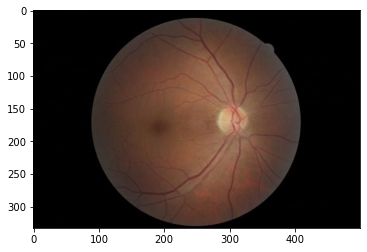

In [208]:
### import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread(".tmp/raw_dataset_extracted_downscaled/train/27755_right.jpeg")
plt.imshow(image)
plt.show()

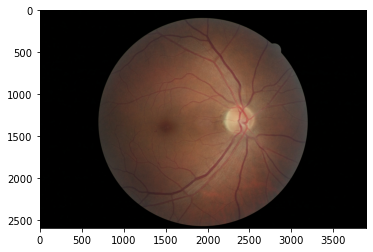

In [209]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread(".tmp/raw_dataset_extracted/train/27755_right.jpeg")
plt.imshow(image)
plt.show()

Hago un resize a un cuarto del tamaño de las imagenes

## Salvado final de todos los datos en storage

Los datos en el disco duro se perderan cuando detenga la VM, asi que guardo los datos en un segmento de storage de google.

In [210]:
! cp .tmp/raw_dataset_extracted/trainLabels.csv .tmp/raw_dataset_extracted_downscaled/trainLabels.csv
! cp .tmp/raw_dataset_extracted/sampleSubmission.csv .tmp/raw_dataset_extracted_downscaled/sampleSubmission.csv

In [211]:
! gsutil -q -m cp -r .tmp/raw_dataset_extracted_downscaled gs://diabetic-detection/data_downscaled

En primera instancia guardo los datos de forma cruda (sin comprimir) porque luego se puedan copiar a una VM (o maquina local) en paralelo.

In [212]:
! zip -q -r '.tmp/raw_dataset_extracted_downscaled.zip' '.tmp/raw_dataset_extracted_downscaled' 

In [213]:
! gsutil -m cp -r .tmp/raw_dataset_extracted_downscaled.zip gs://diabetic-detection/data_downscaled.zip

Copying file://.tmp/raw_dataset_extracted_downscaled.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1/1 files][944.5 MiB/944.5 MiB] 100% Done                                    
Operation completed over 1 objects/944.5 MiB.                                    
